# **Análise entre o Mercado de Trabalho e Portfólio do Senac RN**

## **Objetivos e Metodologias**

**Objetivos:**
- Analisar a situação do mercado de trabalho do Rio Grande do Norte em 2023.
- Avaliar o alinhamento do portfólio de cursos do Senac RN com as necessidades do mercado.

**Metodologia:**
- Coleta de dados do Novo CAGED e do site do Senac RN.
- Análise quantitativa e qualitativa das tendências de mercado e cursos oferecidos.


*fontes:*
-  *https://www.rn.senac.br/*
-  *https://basedosdados.org/dataset/562b56a3-0b01-4735-a049-eeac5681f056?table=b6f74dbb-311a-4c16-b7a9-4e8d6d7caa4b*
-  *http://pdet.mte.gov.br/novo-caged*

## *Pacotes e Bibliotecas*

In [119]:
# Pacotes e Bibliotecas
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from google.oauth2 import service_account
from google.cloud import bigquery

import warnings
warnings.filterwarnings('ignore')

## *Código para os cursos oferecidos pelo SENAC/RN*

### Extração dos cursos oferecidos diretamente do site

In [120]:
# URL do site com a lista de cursos
url = 'https://www.rn.senac.br/todos-os-cursos'

# Requisição para acessar página
resposta_cursos = requests.get(url)
resposta_cursos.raise_for_status()  

# Verifica o HTML usando BeautifulSoup
palavras = BeautifulSoup(resposta_cursos.content, 'html.parser')
cursos = [a.text for a in palavras.select('a')]

# Transforma a lista de nomes em um DataFrame
df_cursos = pd.DataFrame(cursos, columns=['Curso']).reindex()

### Ajustando dataframe para análise

In [121]:
# Excluindo dados que não sejam os cursos
df_cursos = df_cursos.loc[df_cursos['Curso'].str.contains(' - ', na=False)].reset_index(drop=True)

In [122]:
# Separando a classe do curso e o curso propriamente dito
df_cursos[['Classe', 'Curso_senac']] = df_cursos['Curso'].str.split(' - ', n=1, expand=True)
df_cursos = df_cursos.drop(columns='Curso')

# Removendo '\r\n' e espaços em branco adicionais
df_cursos['Classe'] = df_cursos['Classe'].str.replace(r'\s*\r\n\s*', '', regex=True)
df_cursos['Curso_senac'] = df_cursos['Curso_senac'].str.replace(r'\s*\r\n\s+', '', regex=True)

## *Código para acessar banco de dados do Novo CAGED e descrições dos microdados*

### Conectando e consultando o banco de dados BigQuery e planilhas com as descrições dos microdados

In [123]:
# Consultando a chave de acesso ao banco de dados BigQuery
key_path = "D:/Projeto_S/baseprojetos-trab.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

# Configurar o cliente BigQuery
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

Consulta SQL para extração de dataframe

In [124]:
# consulta SQL ao banco de dados de movimentações do CAGED executando os filtros necessários para o projeto
query_movimentacoes = """
    SELECT 
        ano, 
        mes, 
        sigla_uf, 
        cnae_2_secao, 
        cnae_2_subclasse, 
        cbo_2002,
        saldo_movimentacao,
        tipo_movimentacao
    FROM 
        `baseprojetos.caged_rn.caged_rn`
    WHERE 
        ano = 2023
        AND sigla_uf = 'RN'
        --AND tipo_movimentacao IN ('10', '20', '25', '97')
"""

# Executar a consulta e transformar os resultados em um DataFrame
df_caged_sql = client.query(query_movimentacoes).to_dataframe()

# Exibir o DataFrame
df_caged_sql

,ano,mes,sigla_uf,cnae_2_secao,cnae_2_subclasse,cbo_2002,saldo_movimentacao,tipo_movimentacao
0,2023,8,RN,B,810002,784205,1,97
1,2023,8,RN,B,810002,784205,1,97
2,2023,8,RN,B,810099,919105,-1,31
3,2023,8,RN,C,1412601,763320,-1,31
4,2023,8,RN,C,1412601,763215,-1,31
...,...,...,...,...,...,...,...,...
395524,2023,7,RN,T,9700500,391115,1,97
395525,2023,7,RN,G,4635402,521140,-1,98
395526,2023,7,RN,G,4772500,411010,-1,98
395527,2023,7,RN,O,8411600,351105,-1,98


In [125]:
# Dataframes a partir do excel
cnae_secao = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Estabelecimento.xlsx', sheet_name='seção')
cnae_subclasse = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Estabelecimento.xlsx', sheet_name='subclasse')
cbo_2002 = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Movimentação.xlsx', sheet_name='cbo2002ocupação')
tipo_movimentacao = pd.read_excel('D:/Projeto_S/Dados_CAGED/Layout Novo Caged Movimentação.xlsx', sheet_name='tipomovimentação')

### Ajustes dos dataframes para análises

Ajustes dos dataframes para análises

In [126]:
# Ajustando tipo de coluna para cnae_secao
cnae_secao = cnae_secao.rename(
    columns={
        'Código' : 'Cod_secao',
        'Descrição' : 'Desc_secao'
        }
)

# Ajustando tipo de coluna para cnae_subclasse
cnae_subclasse = cnae_subclasse.rename(
    columns={
        'Código' : 'Cod_Subclasse',
        'Descrição' : 'Desc_subclasse'
        }
)
cnae_subclasse['Cod_Subclasse'] = cnae_subclasse['Cod_Subclasse'].astype(str)

# Ajustando tipo de coluna para cbo_2002
cbo_2002 = cbo_2002.rename(
    columns={
        'Código' : 'Cod_cbo_2002',
        'Descrição' : 'Desc_cbo_2002'
        }
)
cbo_2002['Cod_cbo_2002'] = cbo_2002['Cod_cbo_2002'].astype(str)

# Ajustando tipo de coluna para tipo_movimentacao
tipo_movimentacao = tipo_movimentacao.rename(
    columns={
        'Código' : 'Cod_tipo_movimentacao',
        'Descrição' : 'Desc_tipo_movimentacao'
        }
)
tipo_movimentacao['Cod_tipo_movimentacao'] = tipo_movimentacao['Cod_tipo_movimentacao'].astype(str)
tipo_movimentacao = tipo_movimentacao.append(
    {
        'Cod_tipo_movimentacao' : '97',
        'Desc_tipo_movimentacao' : 'Admissão'
    },
    ignore_index=True
)

In [127]:
# Identificando os códigos da tabela df_caged_sql e realizando merge para visualização das descrições de cada coluna
df_analise = pd.merge(df_caged_sql, cnae_secao, left_on='cnae_2_secao', right_on= 'Cod_secao', how='inner')
df_analise = pd.merge(df_analise, cnae_subclasse, left_on='cnae_2_subclasse', right_on='Cod_Subclasse', how='left')
df_analise = pd.merge(df_analise, cbo_2002, left_on='cbo_2002', right_on='Cod_cbo_2002', how='left')
df_analise = pd.merge(df_analise, tipo_movimentacao, left_on='tipo_movimentacao', right_on='Cod_tipo_movimentacao', how='left')

# Excluindo colunas que não serão utilizadas
colunas_excluir = ['sigla_uf','cnae_2_secao', 'cnae_2_subclasse', 'cbo_2002', 'tipo_movimentacao', 'Cod_secao', 'Cod_Subclasse', 'Cod_cbo_2002']
df_analise = df_analise.drop(columns=colunas_excluir)

In [128]:
# Criando coluna de data
df_analise['dia'] = 1
df_analise.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}, inplace=True)
df_analise['mes_ano'] = pd.to_datetime(df_analise[['year', 'month', 'day']])
df_analise['mes_ano'] = df_analise['mes_ano'].dt.strftime('%m/%Y')
df_analise = df_analise.drop(columns=['year', 'month', 'day'])

## *Análises dos dataframes extraídos*

### Visualização do quantitativo de cursos por classe de curso

In [129]:
# Definindo dataframe para análise
df_cursos_viz = df_cursos['Classe'].value_counts().reset_index()
df_cursos_viz.columns = ['Classe', 'Quantidade']

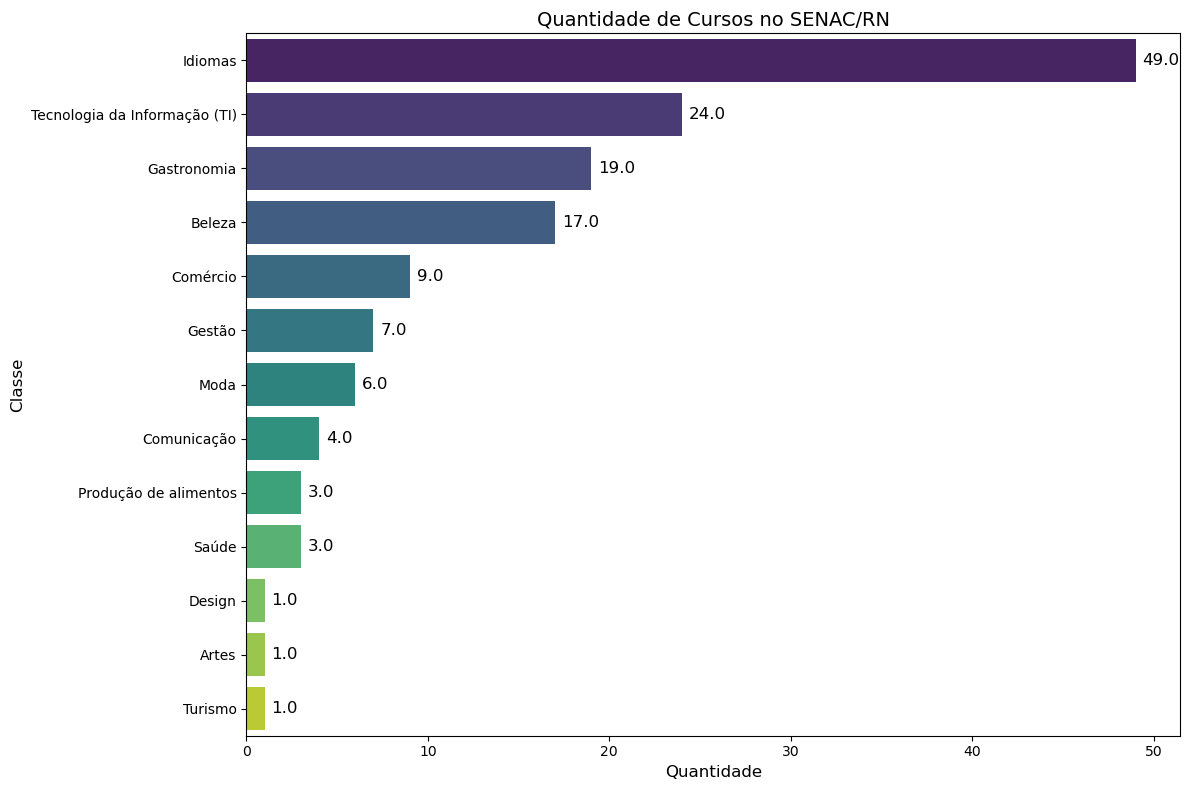

In [130]:
# Criando o gráfico de barras com Seaborn
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(x='Quantidade', y='Classe', data=df_cursos_viz, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=12, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=10)

# Adicionando título e rótulos dos eixos
ax.set_title('Quantidade de Cursos no SENAC/RN', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

*O SENAC/RN oferece uma variedade significativa de cursos, com destaque para Idiomas, que lidera com 49 cursos, refletindo a alta demanda por habilidades linguísticas no mercado globalizado. Tecnologia da Informação (TI) é o segundo maior setor, com 24 cursos, devido à crescente digitalização e transformação digital nas empresas. Gastronomia e Beleza também são áreas fortes, com 19 e 17 cursos, respectivamente, indicando uma demanda constante por habilidades práticas.*

### Análise dos dados CAGED - Admissões

**Quantidade de admissões ao longo de 2023**

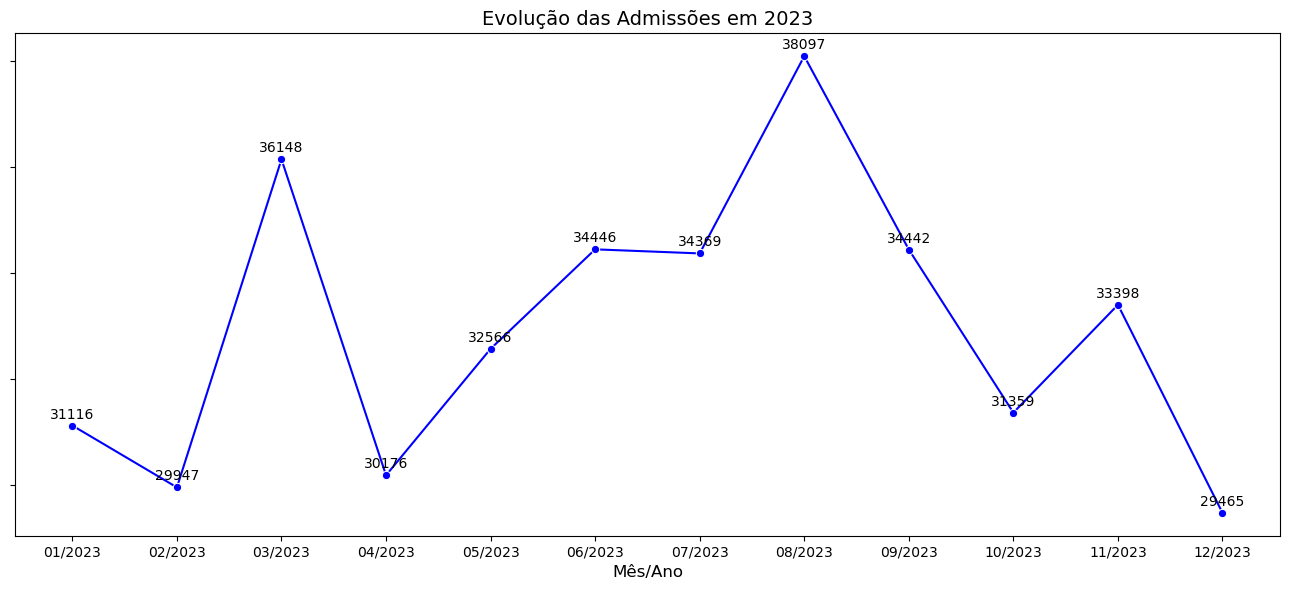

In [131]:
# Dataframe com totais mensais
df_qtd_ano = df_analise.groupby('mes_ano').size().reset_index(name='Quantidade')

# Gráfico de linha
fig, ax = plt.subplots(figsize=(13, 6))

sns.lineplot(x='mes_ano', y='Quantidade', data=df_qtd_ano, marker='o', ax=ax, color='b')

# Adicionando os valores acima de cada ponto
for i, txt in enumerate(df_qtd_ano['Quantidade']):
    ax.annotate(txt, (df_qtd_ano['mes_ano'][i], df_qtd_ano['Quantidade'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)

# Ajuste de rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=-0, fontsize=10)

# Título e rótulos dos eixos
ax.set_title('Evolução das Admissões em 2023', fontsize=14)
ax.set_xlabel('Mês/Ano', fontsize=12)
ax.set_ylabel('')

# Ocultando os rótulos do eixo y
ax.set_yticklabels([])

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

*Em 2023, as admissões de trabalhadores no Rio Grande do Norte apresentaram variações significativas ao longo do ano. Após um início estável, março teve um pico notável de admissões, seguido por uma queda em abril. O meio do ano mostrou uma tendência de recuperação, atingindo o ponto mais alto em agosto, possivelmente devido a contratações sazonais. No final do ano, as admissões diminuíram, com dezembro registrando a menor taxa de admissões, refletindo a conclusão de projetos temporários e a preparação para o período de festas.*

**Quantidade anual de admissões por Atividade Econômica**

In [132]:
# Dataframe com os totais por Seção
df_secao_admissoes = df_analise.groupby('Desc_secao')['saldo_movimentacao'].count().reset_index(name='Quantidade')
df_secao_admissoes = df_secao_admissoes.sort_values(by='Quantidade', ascending=False).reset_index(drop=True)
df_secao_admissoes

,Desc_secao,Quantidade
0,"Comércio, Reparação de Veículos Automotores e ...",100397
1,Construção,63376
2,Atividades Administrativas e Serviços Compleme...,60143
3,Indústrias de Transformação,41150
4,Alojamento e Alimentação,27479
5,"Agricultura, Pecuária, Produção Florestal, Pes...",22359
6,Educação,14707
7,Saúde Humana e Serviços Sociais,13559
8,"Atividades Profissionais, Científicas e Técnicas",13367
9,"Transporte, Armazenagem e Correio",9113


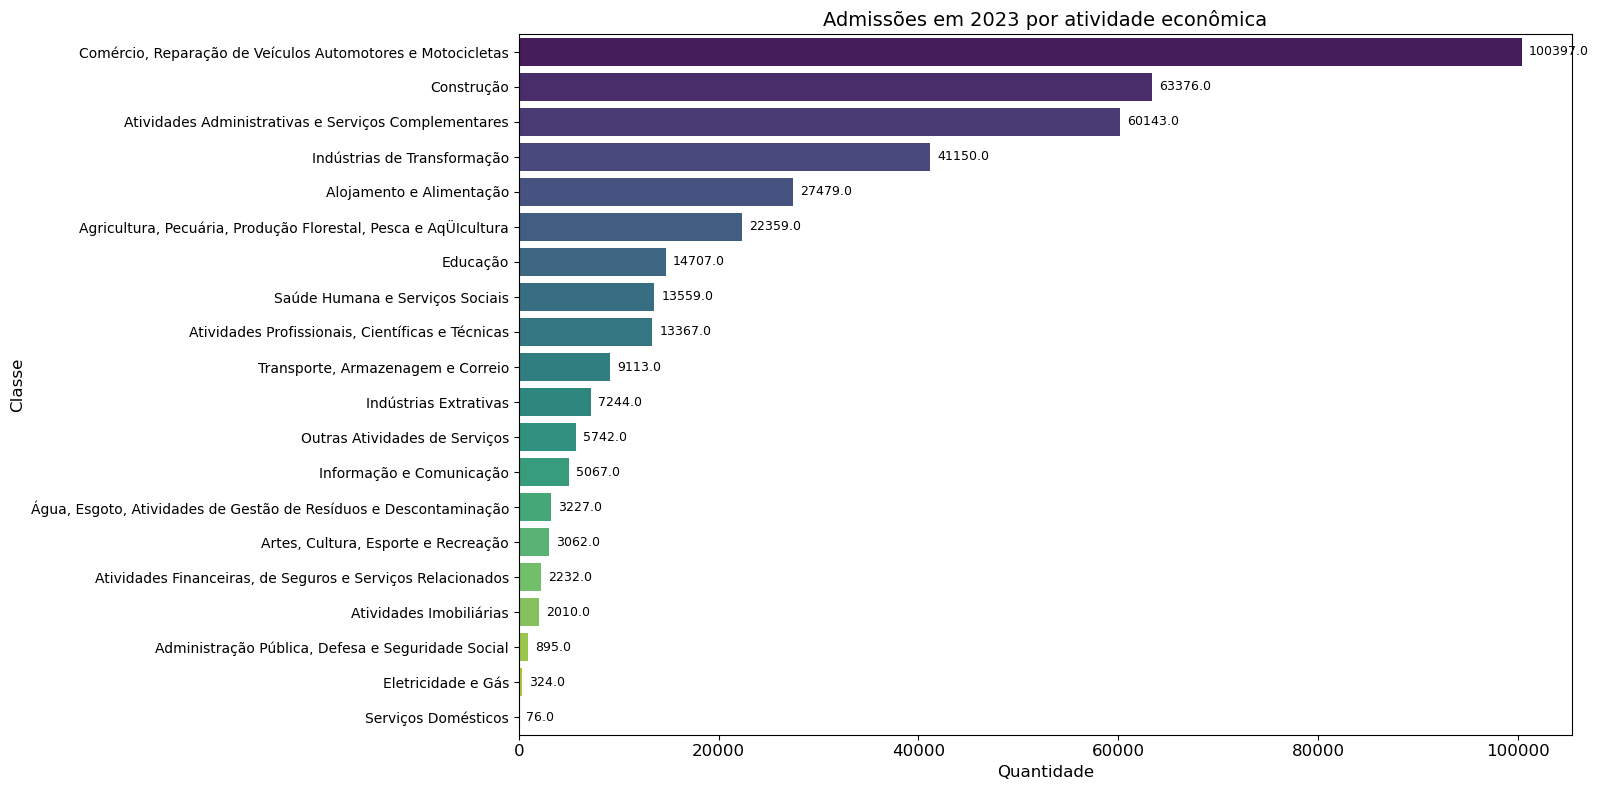

In [133]:
# Gráfico com os totais por atividade econômica
fig2, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='Quantidade', y='Desc_secao', data=df_secao_admissoes, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Admissões em 2023 por atividade econômica', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**Quantidade anual de admissões por CNAE 2.0**

In [134]:
# Dataframe com os totais por Subclasse
df_subclasse_admissoes = df_analise.groupby('Desc_subclasse')['saldo_movimentacao'].count().reset_index(name='Quantidade').nlargest(20, 'Quantidade')
df_subclasse_admissoes = df_subclasse_admissoes.sort_values(by='Quantidade', ascending=False).reset_index(drop=True)
df_subclasse_admissoes

,Desc_subclasse,Quantidade
0,Construção de Edifícios,28371
1,Atividades de Teleatendimento,13756
2,"Comércio Varejista de Mercadorias em Geral, co...",13250
3,"Serviços Combinados para Apoio a Edifícios, Ex...",12562
4,Restaurantes e Similares,12113
5,Cultivo de Melão,9771
6,Comércio Varejista de Artigos do Vestuário e A...,8599
7,Hotéis,6181
8,Construção de Estações e Redes de Distribuição...,5684
9,"Comércio Varejista de Mercadorias em Geral, co...",5620


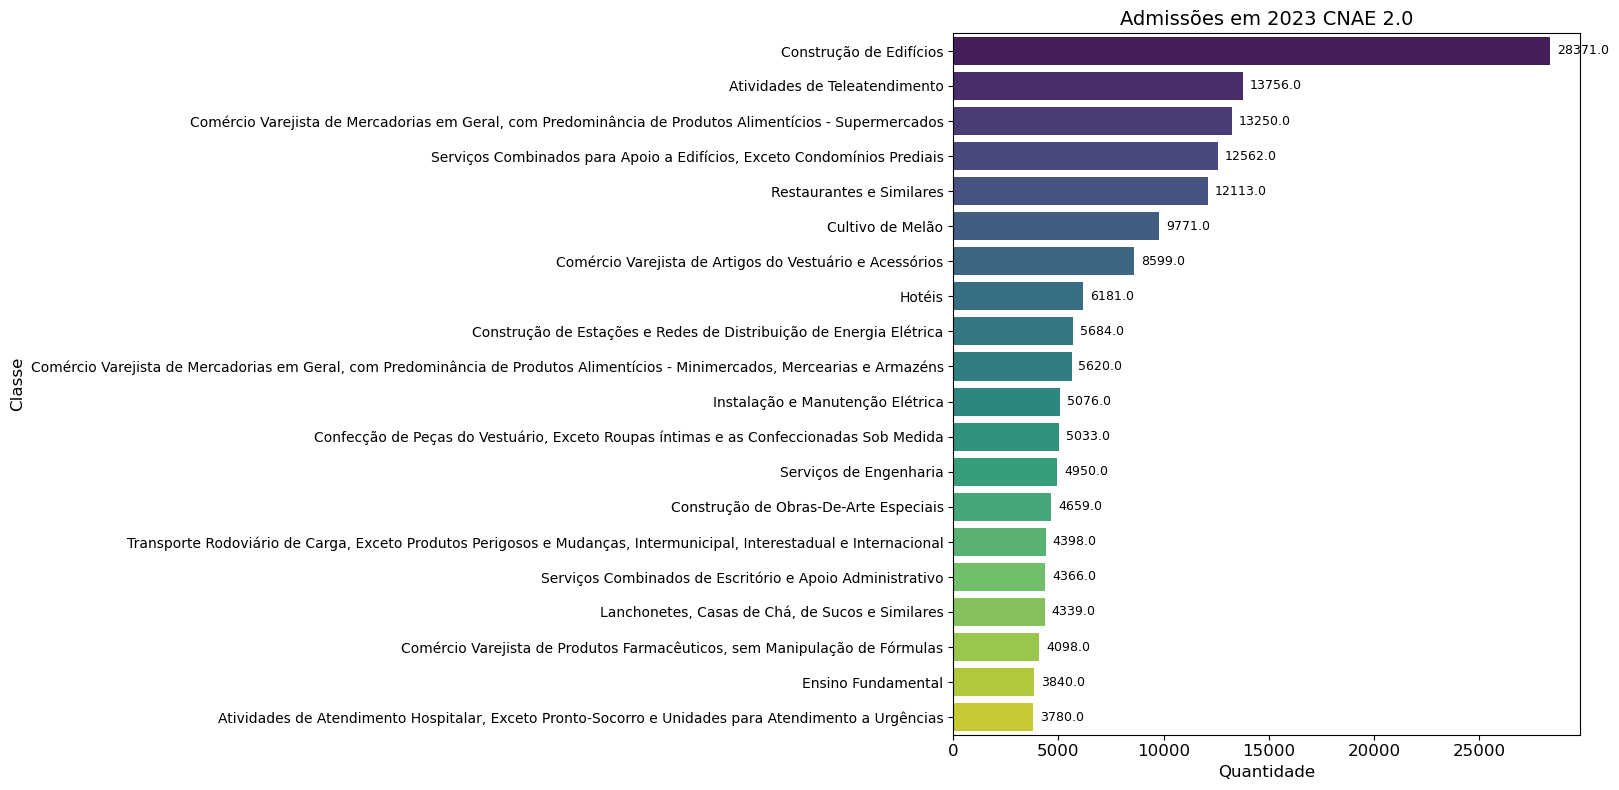

In [135]:
# Gráfico com os totais por subclasse
fig5, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='Quantidade', y='Desc_subclasse', data=df_subclasse_admissoes, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Admissões em 2023 CNAE 2.0', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**Quantidade anual de admissões por CNAE 2.0**

In [136]:
# Dataframe com os totais por CBO
df_cbo_admissoes = df_analise.groupby('Desc_cbo_2002')['saldo_movimentacao'].count().reset_index(name='Quantidade').nlargest(30, 'Quantidade')
df_cbo_admissoes = df_cbo_admissoes.sort_values(by='Quantidade', ascending=False).reset_index(drop=True)
df_cbo_admissoes

,Desc_cbo_2002,Quantidade
0,Servente de Obras,26513
1,Vendedor de Comercio Varejista,24636
2,Faxineiro (Desativado em 2010),16038
3,Operador de Telemarketing Ativo e Receptivo,13305
4,Assistente Administrativo,12888
5,Pedreiro,11351
6,Operador de Caixa,10684
7,"Auxiliar de Escritorio, em Geral",9945
8,Trabalhador no Cultivo de Especies Frutiferas ...,9330
9,Motorista de Caminhao (Rotas Regionais e Inter...,8004


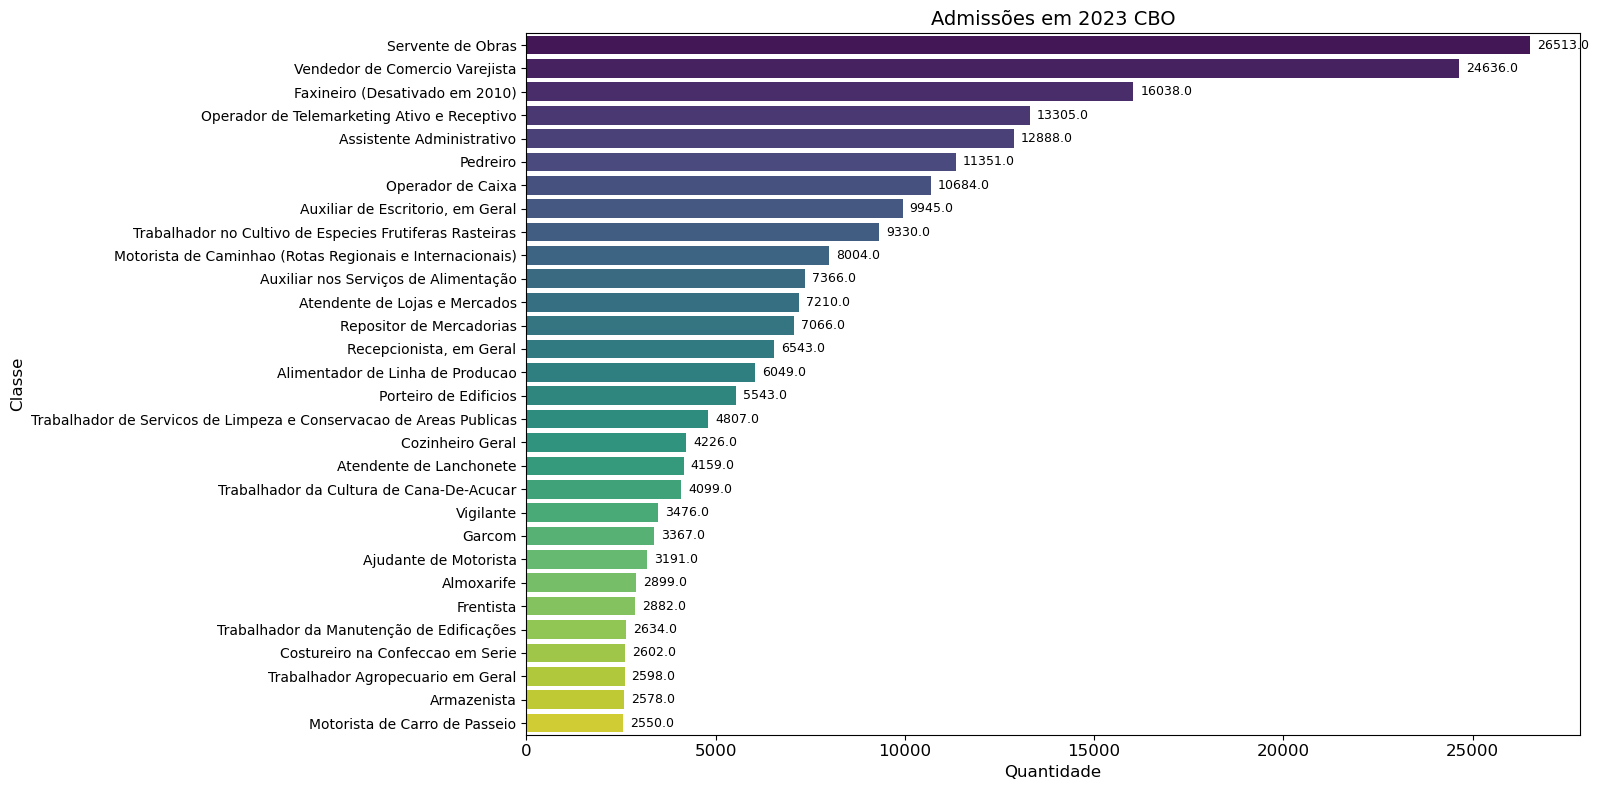

In [137]:
# Gráfico com os totais por CBO
fig5, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='Quantidade', y='Desc_cbo_2002', data=df_cbo_admissoes, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Admissões em 2023 CBO', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**ANÁLISE**

*Os gráficos indicam uma forte demanda por profissionais nas áreas de Comércio, Construção, e Serviços Administrativos. O SENAC/RN oferece cursos alinhados a essas demandas, como Relacionamento com o Cliente e Gerência de Loja, que são essenciais para setores como Teleatendimento e Comércio Varejista.*
*Ocupação com maior número de admissões como Vendedor de Comércio Varejista ressalta a importância de cursos de formação básica e técnica. Cursos como Vendas e Atendimento oferecidos pelo SENAC/RN são diretamente aplicáveis a esta necessidade.*

### Análise dos dados CAGED - Saldo de Admissões

**Saldo de admissões ao longo de 2023**
*(total de admissões - total de demissões)*

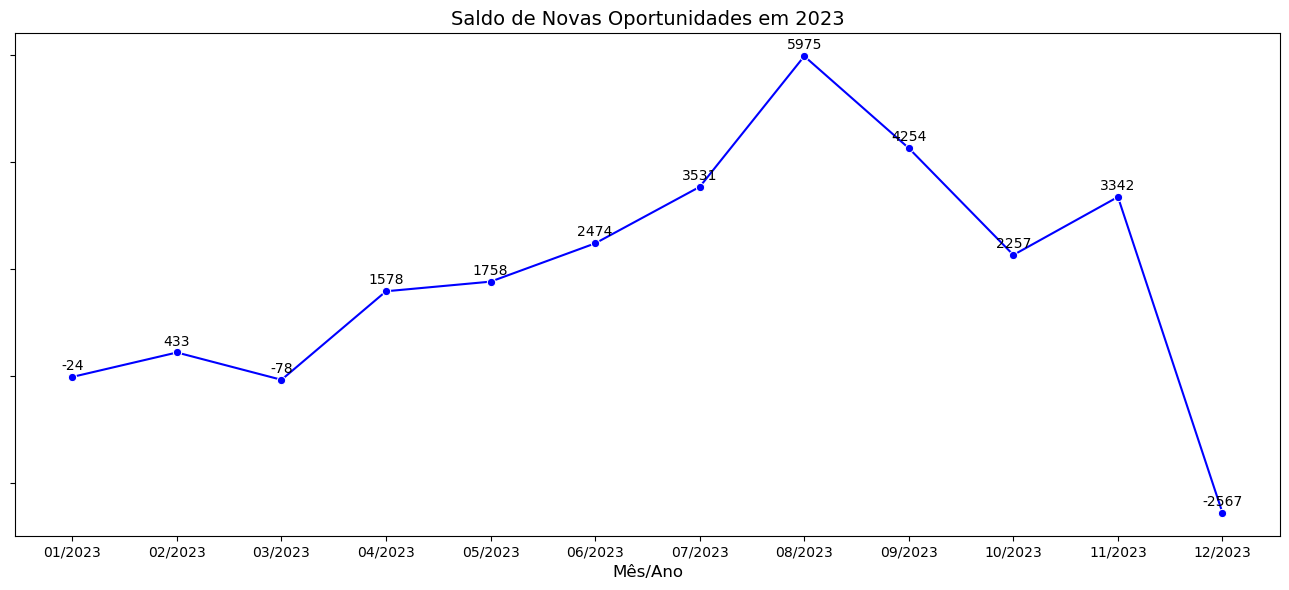

In [138]:
df_saldo_movi_graf = df_analise.groupby('mes_ano')['saldo_movimentacao'].sum().reset_index()

# Criando o gráfico de linha com Seaborn
fig3, ax = plt.subplots(figsize=(13, 6))

sns.lineplot(x='mes_ano', y='saldo_movimentacao', data=df_saldo_movi_graf, marker='o', ax=ax, color='b')

# Adicionando os valores acima de cada ponto
for i, txt in enumerate(df_saldo_movi_graf['saldo_movimentacao']):
    ax.annotate(txt, (df_saldo_movi_graf['mes_ano'][i], df_saldo_movi_graf['saldo_movimentacao'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=-0, fontsize=10)

# Adicionando título e rótulos dos eixos
ax.set_title('Saldo de Novas Oportunidades em 2023', fontsize=14)
ax.set_xlabel('Mês/Ano', fontsize=12)
ax.set_ylabel('')

# Ocultando os rótulos do eixo y
ax.set_yticklabels([])

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

*As novas oportunidades são calculadas a partir da diferença entre as admissões e demissões. Em janeiro, o saldo foi negativo (-24), indicando mais demissões do que admissões. A situação melhorou em fevereiro (433) e março (-78), embora ainda com oscilações. A partir de abril, o saldo tornou-se consistentemente positivo, atingindo um pico em agosto (5975). No entanto, houve uma queda significativa em dezembro (-2567), sugerindo um aumento nas demissões ou uma redução nas admissões. Mesmo apresentação irregularidades durante o período o resultado acumulado foi positivo com 22.933 novas oportunidades.*

**Saldo de admissões anual por Atividade Econômica**

In [139]:
df_secao = df_analise.groupby('Desc_secao')['saldo_movimentacao'].sum().reset_index()
total_secao = df_secao['saldo_movimentacao'].sum()
df_secao['%'] = (df_secao['saldo_movimentacao'] / total_secao) * 100
df_secao['%'] = df_secao['%'].round(2)
df_secao = df_secao.sort_values(by='saldo_movimentacao', ascending=False).reset_index(drop=True)

df_secao

,Desc_secao,saldo_movimentacao,%
0,Atividades Administrativas e Serviços Compleme...,8017,34.96
1,"Comércio, Reparação de Veículos Automotores e ...",4377,19.09
2,Construção,3762,16.4
3,"Agricultura, Pecuária, Produção Florestal, Pes...",1345,5.86
4,Alojamento e Alimentação,867,3.78
5,Indústrias de Transformação,842,3.67
6,Educação,711,3.1
7,"Água, Esgoto, Atividades de Gestão de Resíduos...",477,2.08
8,Indústrias Extrativas,458,2.0
9,"Atividades Profissionais, Científicas e Técnicas",433,1.89


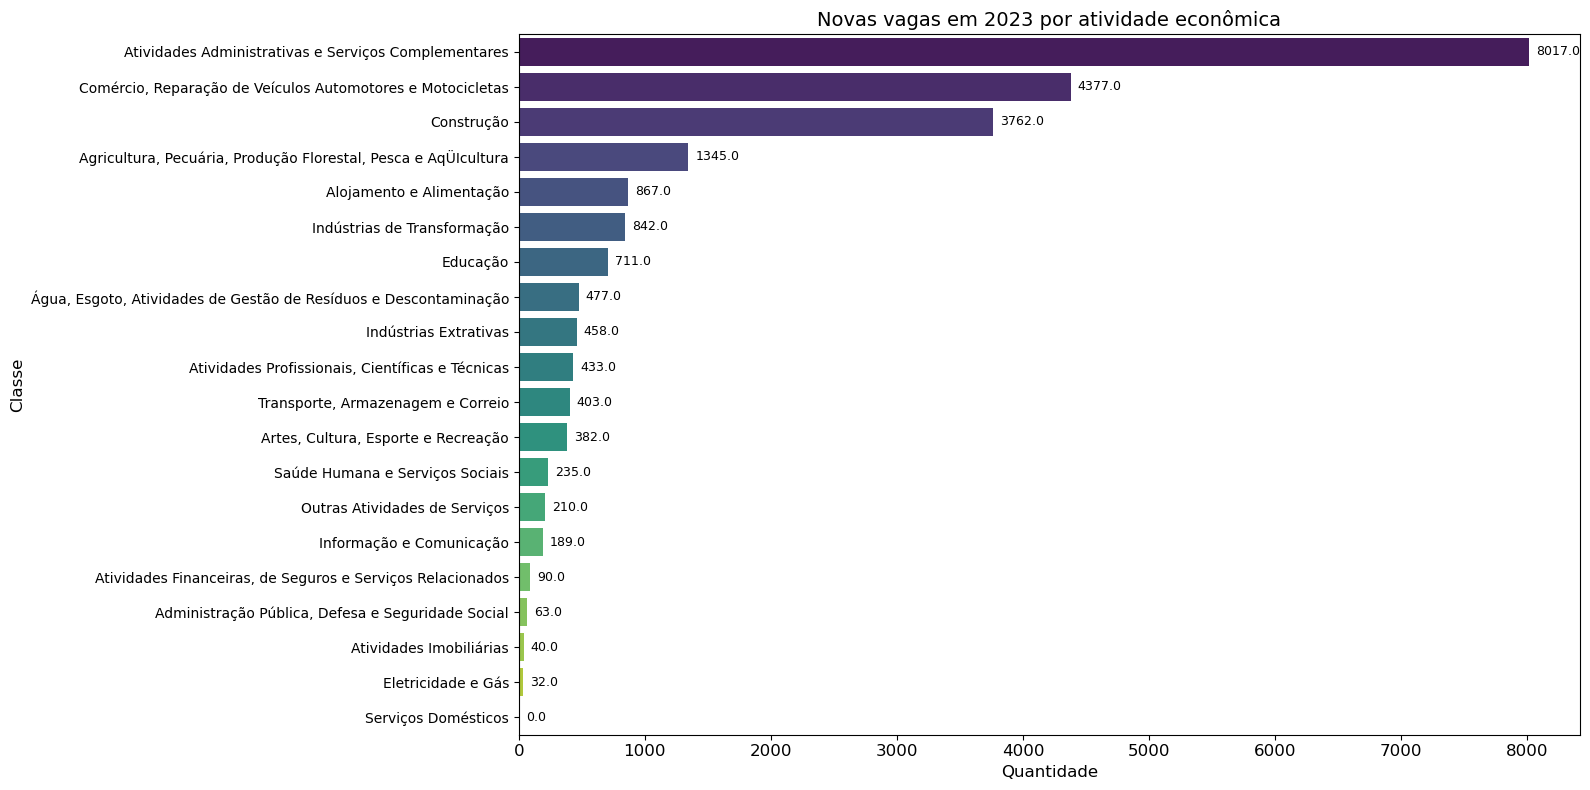

In [140]:
# Criando o gráfico de barras com Seaborn
fig4, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='saldo_movimentacao', y='Desc_secao', data=df_secao, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Novas vagas em 2023 por atividade econômica', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**Saldo de admissões anual por CNAE 2.0**

In [141]:
df_subclasse = df_analise.groupby('Desc_subclasse')['saldo_movimentacao'].sum().reset_index().nlargest(20, 'saldo_movimentacao')
total_secao_subclasse = df_subclasse['saldo_movimentacao'].sum()
df_subclasse['%'] = (df_subclasse['saldo_movimentacao'] / total_secao) * 100
df_subclasse['%'] = df_subclasse['%'].round(2)
df_subclasse = df_subclasse.sort_values(by='saldo_movimentacao', ascending=False).reset_index(drop=True)

df_subclasse

,Desc_subclasse,saldo_movimentacao,%
0,Atividades de Teleatendimento,3494,15.24
1,"Serviços Combinados para Apoio a Edifícios, Ex...",3354,14.63
2,Construção de Edifícios,2219,9.68
3,Instalação e Manutenção Elétrica,940,4.1
4,"Comércio Varejista de Mercadorias em Geral, co...",678,2.96
5,Outras Obras de Engenharia Civil não Especific...,655,2.86
6,Restaurantes e Similares,565,2.46
7,Serviços Combinados de Escritório e Apoio Admi...,536,2.34
8,Comércio Varejista Especializado de Equipament...,534,2.33
9,Construção de Estações e Redes de Distribuição...,506,2.21


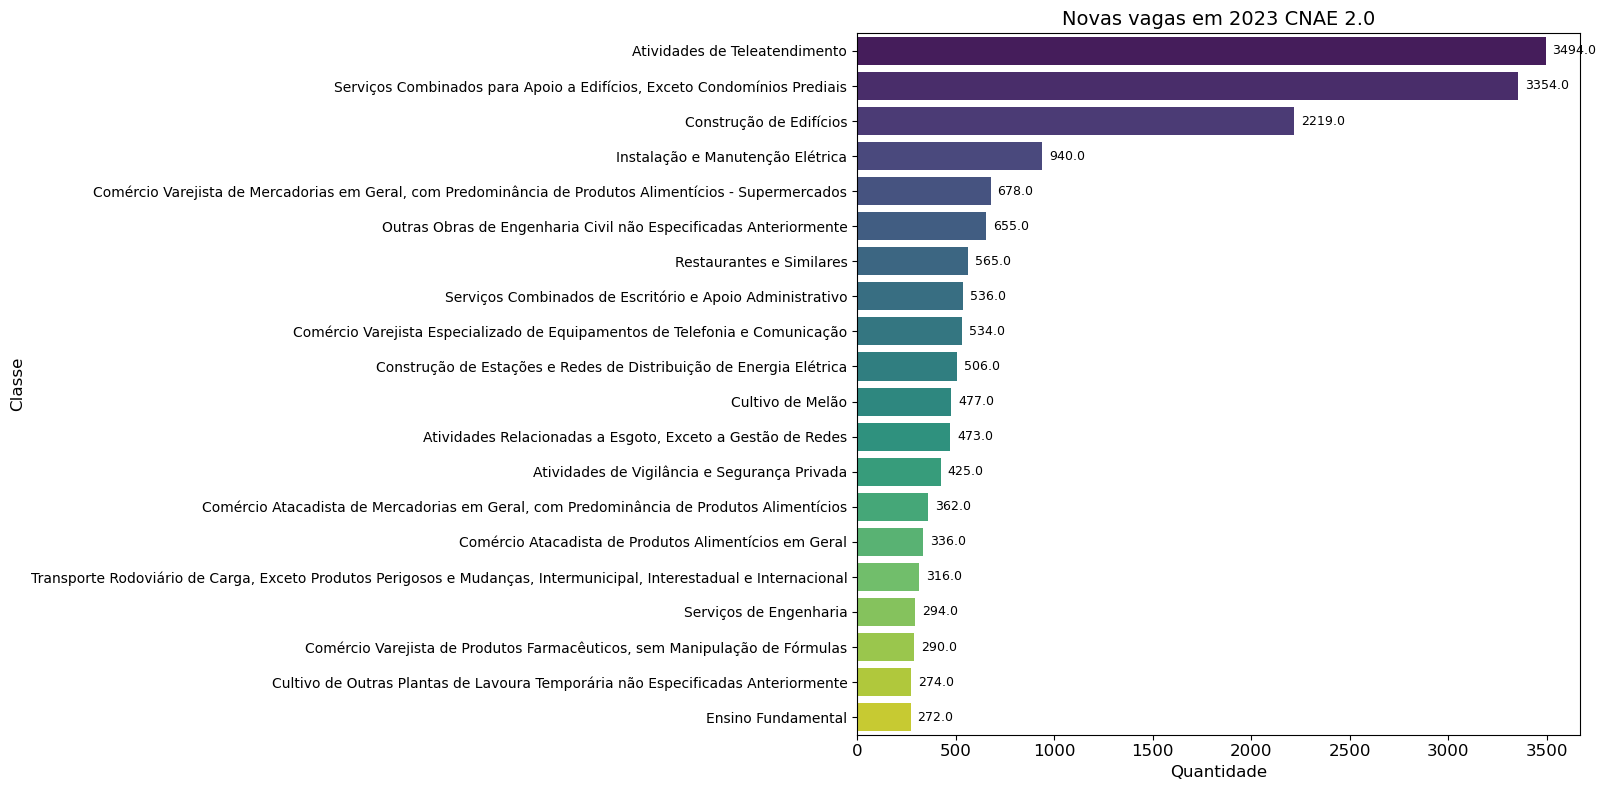

In [142]:
# Criando o gráfico de barras com Seaborn
fig4, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='saldo_movimentacao', y='Desc_subclasse', data=df_subclasse, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Novas vagas em 2023 CNAE 2.0', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**Saldo de admissões anual por CBO**

In [143]:
df_cbo = df_analise.groupby('Desc_cbo_2002')['saldo_movimentacao'].sum().reset_index().nlargest(20, 'saldo_movimentacao')
total_secao_cbo = df_cbo['saldo_movimentacao'].sum()
df_cbo['%'] = (df_cbo['saldo_movimentacao'] / total_secao) * 100
df_cbo['%'] = df_cbo['%'].round(2)
df_cbo = df_cbo.sort_values(by='saldo_movimentacao', ascending=False).reset_index(drop=True)

df_cbo

,Desc_cbo_2002,saldo_movimentacao,%
0,Operador de Telemarketing Ativo e Receptivo,3519,15.34
1,Servente de Obras,2669,11.64
2,Faxineiro (Desativado em 2010),1944,8.48
3,Assistente Administrativo,1450,6.32
4,Atendente de Lojas e Mercados,1036,4.52
5,"Auxiliar de Escritorio, em Geral",797,3.48
6,Alimentador de Linha de Producao,721,3.14
7,Auxiliar nos Serviços de Alimentação,714,3.11
8,Pedreiro,693,3.02
9,"Recepcionista, em Geral",573,2.5


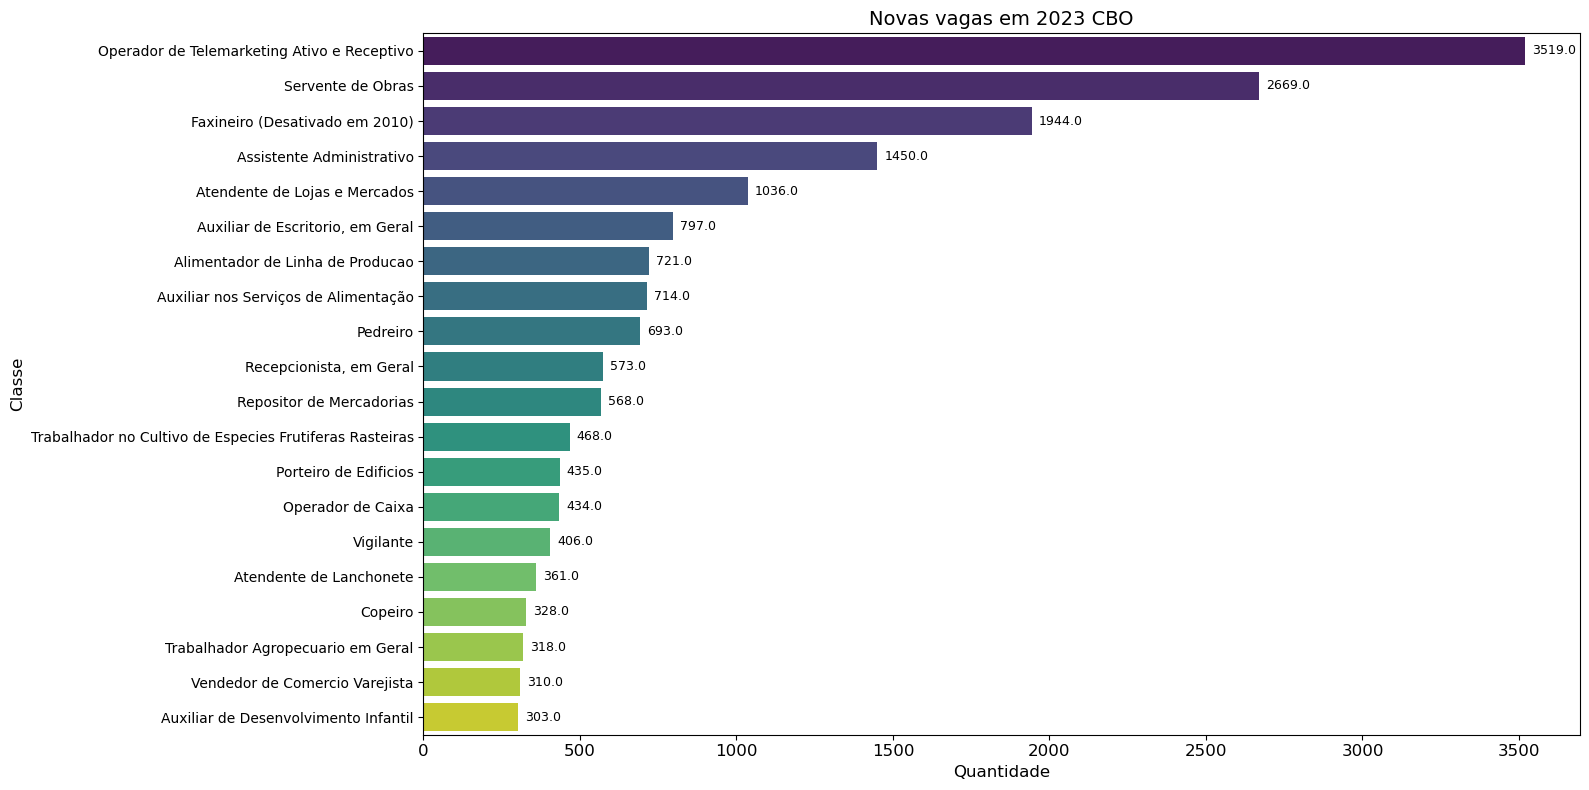

In [144]:
# Criando o gráfico de barras com Seaborn
fig4, ax = plt.subplots(figsize=(16, 8))

sns.barplot(x='saldo_movimentacao', y='Desc_cbo_2002', data=df_cbo, ax=ax, palette='viridis', orient='h')

# Adicionando os valores ao lado das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9, color='black', xytext=(5, 0), 
                textcoords='offset points')

# Ajustando a rotação dos rótulos do eixo x e o tamanho da fonte
plt.xticks(rotation=0, fontsize=12)

# Adicionando título e rótulos dos eixos
ax.set_title('Novas vagas em 2023 CBO', fontsize=14)
ax.set_xlabel('Quantidade', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Alterando a cor de fundo da figura e dos eixos
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

**ANÁLISE**

*Os cursos oferecidos pelo SENAC RN em 2023 estão, em grande parte, alinhados com as demandas do mercado de trabalho do estado. Setores como "Atividades Administrativas", "Comércio" e "Construção" possuem cursos específicos que preparam bem os profissionais. No entanto, há áreas em crescimento como "Agricultura" e "Indústrias de Transformação" que apresentam uma lacuna na oferta de cursos. Além disso, profissões como "Operador de Telemarketing" e "Servente de Obras" são altamente demandadas, indicando a necessidade de mais cursos práticos e especializados. Expandir a oferta de cursos nessas áreas emergentes pode melhorar a preparação dos profissionais para as oportunidades do mercado local.*

## *Conclusões Finais*

*As análises demonstram que os cursos oferecidos pelo SENAC RN estão alinhados com várias necessidades do mercado de trabalho do estado, especialmente nos setores de "Atividades Administrativas“ e "Comércio". No entanto, áreas emergentes como "Agricultura" e "Indústrias de Transformação" ainda apresentam lacunas na oferta de cursos, indicando oportunidades para expandir a formação nessas áreas.*

*Também foi observada uma alta demanda por profissões específicas como "Operador de Telemarketing" e "Servente de Obras", sugerindo que o foco em cursos práticos e especializados para essas ocupações pode ser benéfico.*

*É recomendado que o SENAC RN continue monitorando as tendências do mercado de trabalho e ajustando sua oferta de cursos para preencher as lacunas identificadas. Essa abordagem aumentará a empregabilidade dos alunos e contribuirá significativamente para o desenvolvimento econômico do estado.*

*Ao alinhar ainda mais os programas de formação com as demandas do mercado, o SENAC RN solidificará seu papel como um catalisador essencial para o crescimento profissional e econômico da região.*
